In [26]:
import time
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import pyvirtualdisplay
import imageio
from collections import deque, namedtuple
import utils
import PIL.Image
from tensorflow.keras.losses import MSE

In [2]:
MEMORY_SIZE = 100_000
GAMMA = 0.995
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 4

In [3]:
env = gym.make("LunarLander-v2",render_mode="human")
env.reset()

(array([ 0.00437746,  1.4078491 ,  0.443366  , -0.13649315, -0.00506551,
        -0.100429  ,  0.        ,  0.        ], dtype=float32),
 {})

In [4]:
state_size = env.observation_space.shape
num_actions = env.action_space.n
print(state_size)
print(num_actions)

(8,)
4


In [5]:
initial_state = env.reset()

In [ ]:
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, truncated, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

In [ ]:
q_network = Sequential([
    tf.keras.layers.Input(shape = state_size),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(num_actions,activation = 'linear')
])
target_q_network = Sequential([
    tf.keras.layers.Input(shape = state_size),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(num_actions,activation = 'linear')
])
optimizer = Adam(ALPHA)


In [12]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [13]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [14]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [15]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    state = state[0]
    #print(type(state))
    # Convert to numpy array if it's not already
    #state = np.array(state)
    
    # Flatten the state if it's multi-dimensional
    state = state.flatten()
    total_points = 0
    print(type(state))
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, truncated, info = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

<class 'numpy.ndarray'>
Episode 1 | Total point average of the last 100 episodes: -108.74<class 'numpy.ndarray'>
Episode 2 | Total point average of the last 100 episodes: -117.28<class 'numpy.ndarray'>
Episode 3 | Total point average of the last 100 episodes: -79.12<class 'numpy.ndarray'>
Episode 4 | Total point average of the last 100 episodes: -75.26<class 'numpy.ndarray'>
Episode 5 | Total point average of the last 100 episodes: -62.66<class 'numpy.ndarray'>
Episode 6 | Total point average of the last 100 episodes: -84.02<class 'numpy.ndarray'>
Episode 7 | Total point average of the last 100 episodes: -118.55<class 'numpy.ndarray'>
Episode 8 | Total point average of the last 100 episodes: -135.12<class 'numpy.ndarray'>
Episode 9 | Total point average of the last 100 episodes: -128.62<class 'numpy.ndarray'>
Episode 10 | Total point average of the last 100 episodes: -131.13<class 'numpy.ndarray'>
Episode 11 | Total point average of the last 100 episodes: -120.37<class 'numpy.ndarray'>

Episode 617 | Total point average of the last 100 episodes: 201.50

Environment solved in 617 episodes!

Total Runtime: 6788.18 s (113.14 min)


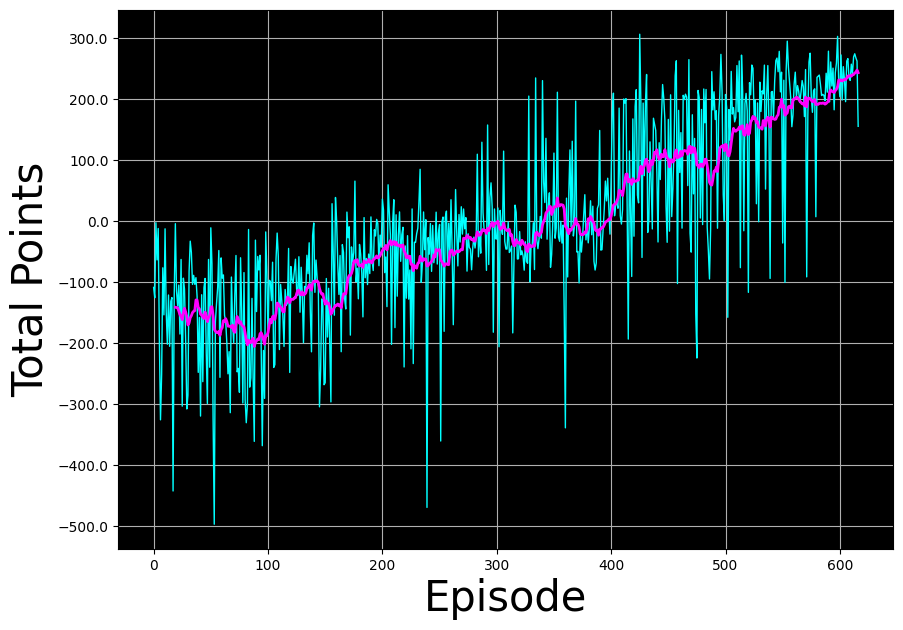

In [40]:
import utils
utils.plot_history(total_point_history)

In [27]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [33]:
def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        terminated = False
        truncated = False
        state, _ = env.reset()
        while not (terminated or truncated):
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, reward, terminated, truncated, info = env.step(action)
            frame = env.render()
            video.append_data(frame)
    
    env.close()
env = gym.make("LunarLander-v2", render_mode="rgb_array")
create_video("output.mp4", env, q_network)

[swscaler @ 0x6285c00] Warning: data is not aligned! This can lead to a speed loss
